In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)



import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Archive'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

Streaming output truncated to the last 5000 lines.
/content/drive/MyDrive/Archive/archive (1)/chest_xray/train/NORMAL/NORMAL2-IM-1202-0001.jpeg
/content/drive/MyDrive/Archive/archive (1)/chest_xray/train/NORMAL/NORMAL2-IM-1179-0001.jpeg
/content/drive/MyDrive/Archive/archive (1)/chest_xray/train/NORMAL/NORMAL2-IM-1192-0001.jpeg
/content/drive/MyDrive/Archive/archive (1)/chest_xray/train/NORMAL/NORMAL2-IM-1200-0001.jpeg
/content/drive/MyDrive/Archive/archive (1)/chest_xray/train/NORMAL/NORMAL2-IM-1197-0001.jpeg
/content/drive/MyDrive/Archive/archive (1)/chest_xray/train/NORMAL/NORMAL2-IM-1201-0001.jpeg
/content/drive/MyDrive/Archive/archive (1)/chest_xray/train/NORMAL/NORMAL2-IM-1219-0001.jpeg
/content/drive/MyDrive/Archive/archive (1)/chest_xray/train/NORMAL/NORMAL2-IM-1185-0001.jpeg
/content/drive/MyDrive/Archive/archive (1)/chest_xray/train/NORMAL/NORMAL2-IM-1205-0001.jpeg
/content/drive/MyDrive/Archive/archive (1)/chest_xray/train/NORMAL/NORMAL2-IM-1188-0001.jpeg
/content/drive/MyDr

# Importing the necessary libraries

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

In [4]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

# Loading the Dataset

In [5]:
train = get_training_data('/content/drive/MyDrive/Archive/archive (1)/chest_xray/train')
test = get_training_data('/content/drive/MyDrive/Archive/archive (1)/chest_xray/test')
val = get_training_data('/content/drive/MyDrive/Archive/archive (1)/chest_xray/test')

<ipython-input-4-b2613b36a4a4>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


# Data Visualization & Preprocessing

<Axes: xlabel='Label', ylabel='count'>

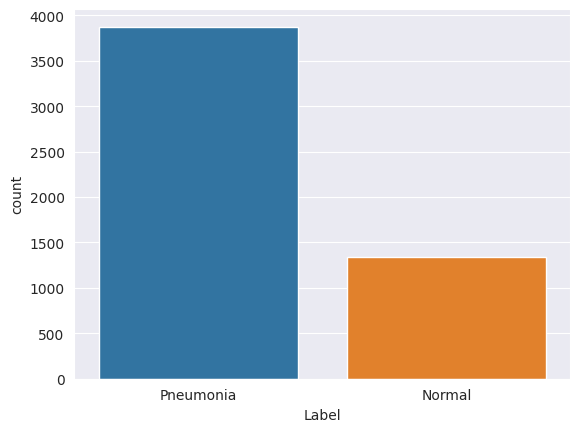

In [10]:
data = pd.DataFrame({'Label': l})

sns.set_style('darkgrid')
sns.countplot(data=data, x='Label')

In [ ]:
l = []
for i in train:
    if i[1] == 0:
        l.append("Pneumonia")
    else:
        l.append("Normal")

sns.set_style('darkgrid')
sns.countplot(l) 

**The data seems imbalanced . To increase the no. of training examples, we will use data augmentation**

**Previewing the images of both the classes**

Text(0.5, 1.0, 'NORMAL')

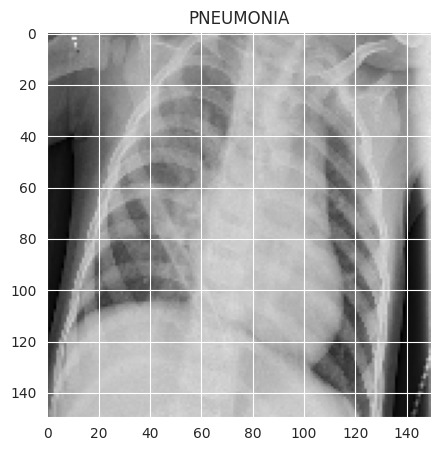

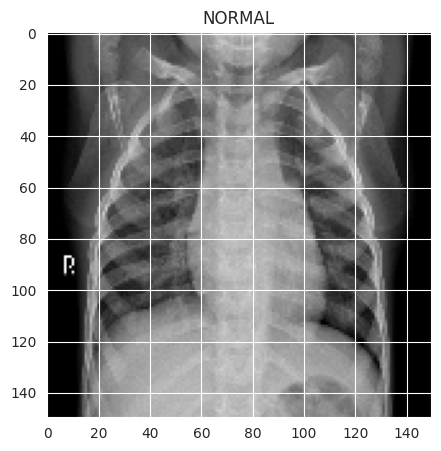

In [11]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [12]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

**We perform a grayscale normalization to reduce the effect of illumination's differences.Moreover the CNN converges faster on [0..1] data than on [0..255].**

In [13]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [14]:
# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

# Data Augmentation
**In order to avoid overfitting problem, we need to expand artificially our dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations.
Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more.
By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.**

In [15]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

For the data augmentation, i choosed to :
1. Randomly rotate some training images by 30 degrees 
2. Randomly Zoom by 20% some training images
3. Randomly shift images horizontally by 10% of the width 
4. Randomly shift images vertically by 10% of the height 
5. Randomly flip images horizontally.
Once our model is ready, we fit the training dataset.

# Training the Model

In [16]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 75, 75, 64)       2

In [17]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [18]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 12 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/12
163/163 [==============================] - 450s 3s/step - loss: 0.6108 - accuracy: 0.8340 - val_loss: 21.8362 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 2/12
163/163 [==============================] - 437s 3s/step - loss: 0.2641 - accuracy: 0.8911 - val_loss: 55.1053 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 3/12
163/163 [==============================] - ETA: 0s - loss: 0.2184 - accuracy: 0.9187
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 438s 3s/step - loss: 0.2184 - accuracy: 0.9187 - val_loss: 41.4383 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 4/12
163/163 [==============================] - 436s 3s/step - loss: 0.1709 - accuracy: 0.9452 - val_loss: 10.7459 - val_accuracy: 0.6298 - lr: 3.0000e-04
Epoch 5/12
163/163 [==============================] - 427s 3s/step - loss: 0.1416 - accuracy: 0.9475 - val_loss: 0.7503 - val_accuracy: 0.7115 - lr: 3.0000e-04
Epoch 6/12
163/163 [===========================

In [19]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 12s 570ms/step - loss: 0.3441 - accuracy: 0.8990
Loss of the model is -  0.34405913949012756
20/20 [==============================] - 11s 566ms/step - loss: 0.3441 - accuracy: 0.8990
Accuracy of the model is -  89.90384340286255 %


# Analysis after Model Training

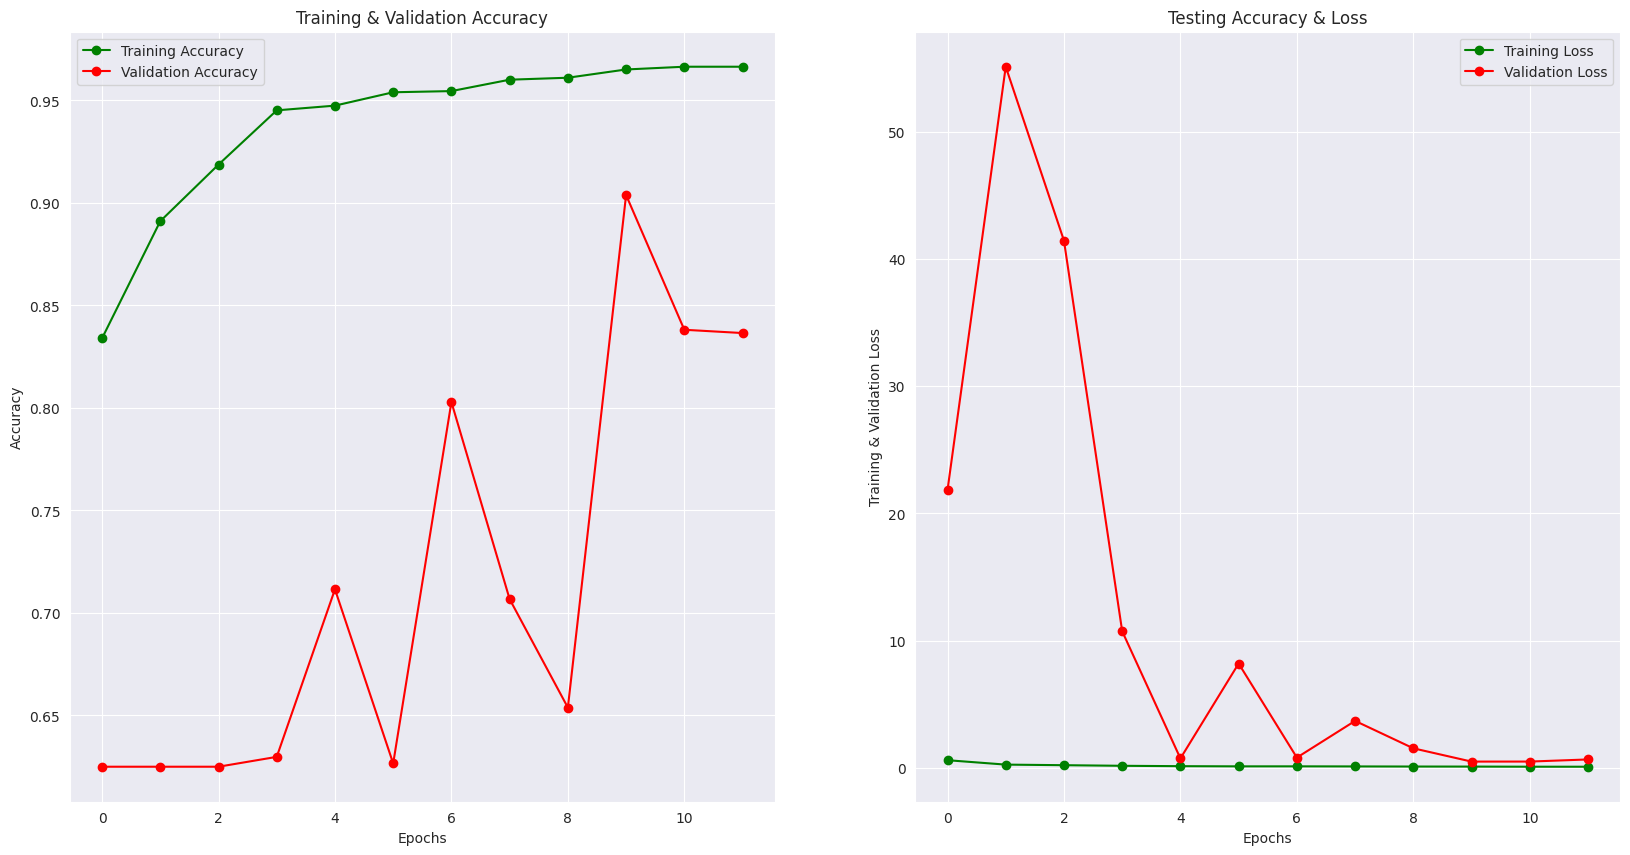

In [20]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [22]:
predictions = model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)
predicted_classes[:15]

20/20 [==============================] - 10s 449ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

In [24]:
threshold = 0.5
predicted_classes = np.where(predictions > threshold, 1, 0)

# Print the classification report
print(classification_report(y_test, predicted_classes, target_names=['Pneumonia (Class 0)', 'Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.94      0.89      0.92       390
   Normal (Class 1)       0.84      0.91      0.87       234

           accuracy                           0.90       624
          macro avg       0.89      0.90      0.89       624
       weighted avg       0.90      0.90      0.90       624



In [26]:
cm = confusion_matrix(y_test,predicted_classes)
cm

array([[348,  42],
       [ 21, 213]])

In [27]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

<Axes: >

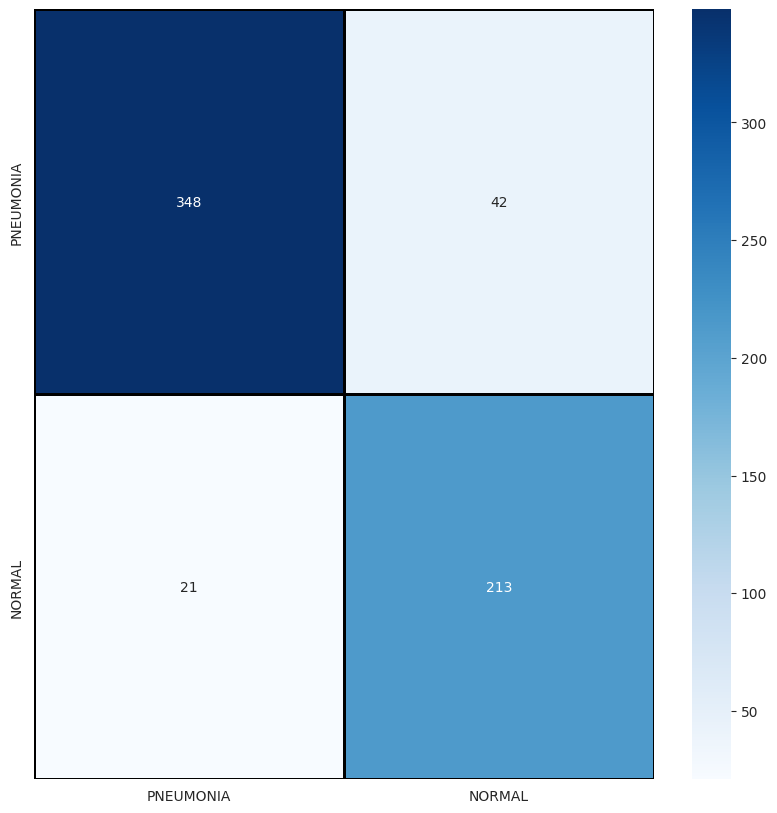

In [28]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [30]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

**Some of the Correctly Predicted Classes**

<ipython-input-41-3eefbc047aac>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 2, i + 1)


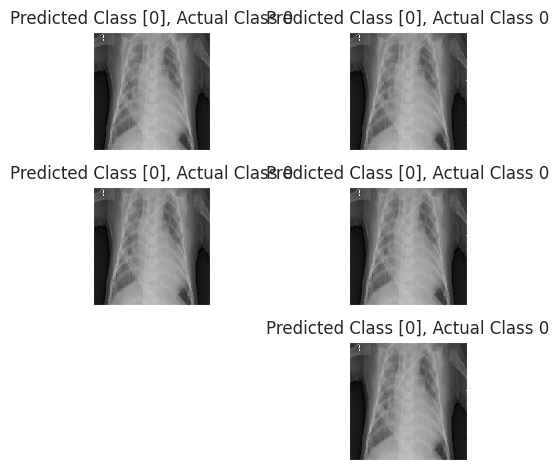

In [41]:
incorrect_indices = [idx for idx, (pred, actual) in enumerate(zip(predicted_classes, y_test)) if pred == actual]
i = 0


for c in correct_indices[:6]:
    plt.subplot(3, 2, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150, 150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {}, Actual Class {}".format(predicted_classes[c], y_test[c]))
    plt.tight_layout()
    i += 1


**Some of the Incorrectly Predicted Classes**

<ipython-input-40-2d35c813e2f6>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 2, i + 1)


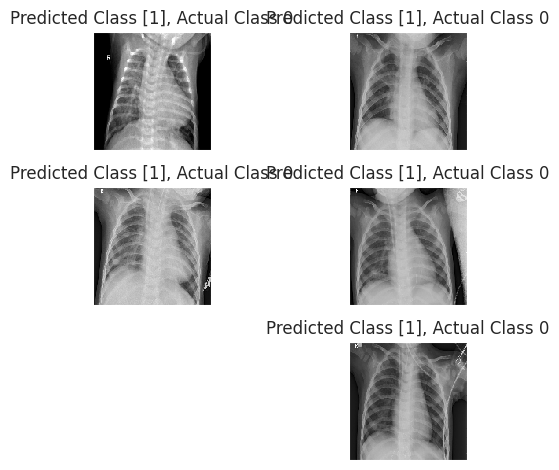

In [40]:
incorrect_indices = [idx for idx, (pred, actual) in enumerate(zip(predicted_classes, y_test)) if pred != actual]
i=0
for c in incorrect_indices[:6]:
    plt.subplot(3, 2, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150, 150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {}, Actual Class {}".format(predicted_classes[c], y_test[c]))
    plt.tight_layout()
    i += 1